# Finite Markov Chains: Examples

**Daisuke Oyama**

*Faculty of Economics, University of Tokyo*

This notebook demonstrates how to analyze finite-state Markov chains
with the `MarkovChain` class.
For basic concepts and properties on Markov chains, see

* [the lecture on finite Markov chains](http://quant-econ.net/py/finite_markov.html)
  in Quantitative Economics, and
* [the documentation for `MarkovChain`](http://quanteconpy.readthedocs.org/en/stable/markov/core.html).

For algorithmic issues in detecting reducibility and periodicity of a Markov chain,
see, for example,

* J. P. Jarvis and D. R. Shier,
  "[Graph-Theoretic Analysis of Finite Markov Chains](http://www.ces.clemson.edu/~shierd/Shier/markov.pdf),"

from which we draw some examples below.

In [1]:
using PyPlot
using QuantEcon

In [2]:
T = 0.5       # Time expiration (years)
vol = 0.2     # Annual volatility
r = 0.05      # Annual interest rate
strike = 2.1  # Strike price
p0 = 2        # Current price
N = 100       # Number of periods to expiration

# Time length of a period
tau = T/N

# Discount factor
beta = exp(-r*tau)

# Up-jump factor
u = exp(vol*sqrt(tau))

# Up-jump probability
q = 1/2 + sqrt(tau)*(r - vol^2/2)/(2*vol)

0.5053033008588991

In [3]:
P = zeros(6, 6)
P[1, 1] = 1
P[2, 5] = 1
P[3, 3], P[3, 4], P[3, 5] = 1/3, 1/3, 1/3
P[4, 1], P[4, 6] = 1/2, 1/2
P[5, 2], P[5, 5] = 1/2, 1/2
P[6, 1], P[6, 4] = 1/2, 1/2

(0.5,0.5)

Create a MarkovChain instance:

In [10]:
mc1 = MarkovChain(P)

Discrete Markov Chain
stochastic matrix of type Array{Float64,2}:
[1.0 0.0 … 0.0 0.0; 0.0 0.0 … 1.0 0.0; … ; 0.0 0.5 … 0.5 0.0; 0.5 0.0 … 0.0 0.0]

### Classification of states

This Markov chain is reducible:

In [5]:
is_irreducible(mc1)

false

In [12]:
length(communication_classes(mc1))

4

Determine the communication classes:

In [9]:
communication_classes(mc1)

4-element Array{Array{Int64,1},1}:
 [1]  
 [2,5]
 [4,6]
 [3]  

Classify the states of this Markov chain:

In [13]:
recurrent_classes(mc1)

2-element Array{Array{Int64,1},1}:
 [1]  
 [2,5]

Obtain a list of the recurrent states:

In [23]:
recurrent_states = vcat(recurrent_classes(mc1)...)
recurrent_states

3-element Array{Int64,1}:
 1
 2
 5

Obtain a list of the transient states:

In [24]:
transient_states = setdiff(collect(1:n_states(mc1)), recurrent_states)
transient_states

3-element Array{Int64,1}:
 3
 4
 6

A Markov chain is reducible (i.e., its directed graph is not strongly connected)
if and only if by symmetric permulations of rows and columns,
its transition probability matrix is written in the form ("canonical form")
$$
\begin{pmatrix}
U & 0 \\
W & V
\end{pmatrix},
$$
where $U$ and $W$ are square matrices.

Such a form for `mc1` is obtained by the following:

In [27]:
permutation = vcat(recurrent_states, transient_states)
mc1.p[permutation, :][:, permutation]

6×6 Array{Float64,2}:
 1.0  0.0  0.0       0.0       0.0       0.0
 0.0  0.0  1.0       0.0       0.0       0.0
 0.0  0.5  0.5       0.0       0.0       0.0
 0.0  0.0  0.333333  0.333333  0.333333  0.0
 0.5  0.0  0.0       0.0       0.0       0.5
 0.5  0.0  0.0       0.0       0.5       0.0

This Markov chain is aperiodic
(i.e., the least common multiple of the periods of the recurrent sub-chains is one):

In [28]:
is_aperiodic(mc1)

true

Indeed, each of the sub-chains corresponding to the recurrent classes has period $1$,
i.e., every recurrent state is aperiodic:

In [33]:
for recurrent_class in recurrent_classes(mc1)
    sub_matrix = mc1.p[recurrent_class, :][:, recurrent_class]
    d = period(MarkovChain(sub_matrix))
    println("Period of the sub-chain\n $sub_matrix \n = $d")
end

Period of the sub-chain
 [1.0] 
 = 1
Period of the sub-chain
 [0.0 1.0; 0.5 0.5] 
 = 1


### Stationary distributions

For each recurrent class $C$, there is a unique stationary distribution $\psi^C$
such that $\psi^C_i > 0$ for all $i \in C$ and $\psi^C_i = 0$ otherwise.
`MarkovChain.stationary_distributions` returns
these unique stationary distributions for the recurrent classes.
Any stationary distribution is written as a convex combination of these distributions.

In [35]:
stationary_distributions(mc1)

2-element Array{Array{Float64,1},1}:
 [1.0,0.0,0.0,0.0,0.0,0.0]          
 [0.0,0.333333,0.0,0.0,0.666667,0.0]

These are indeed stationary distributions:

In [42]:
mc1.p * stationary_distributions(mc1)[1]

6-element Array{Float64,1}:
 1.0
 0.0
 0.0
 0.5
 0.0
 0.5

In [43]:
mc1.p * stationary_distributions(mc1)[2]

6-element Array{Float64,1}:
 0.0     
 0.666667
 0.222222
 0.0     
 0.5     
 0.0     

Plot these distributions.

In [44]:
function draw_histogram(distribution; ax=nothing, figsize=nothing,
    title=nothing, xlabel=nothing, ylabel=nothing, ylim=(0, 1))
    """
    Plot the given distribution.
    """
    if ax != nothing
        fig, ax = figsize != nothing ? subplots(figsize=figsize) : subplots()
    end
    
    n = length(distribution)
    ax[:bar](collect(1:n), distribution, align="center")
    #bar(1:n, distribution, align="center")
    ax[:set_xlim](-0.5, (n-1)+0.5)
    ax[:set_ylim](ylim)
    if title != nothing
        ax[:set_title](title)
    end
    
    if xlabel != nothing
        ax[:set_xlabel](xlabel)
    end
    
    if ylabel != nothing
        ax[:set_ylabel](ylabel)
    end
    
    if ax != nothing
        show()
    end
end


draw_histogram (generic function with 1 method)

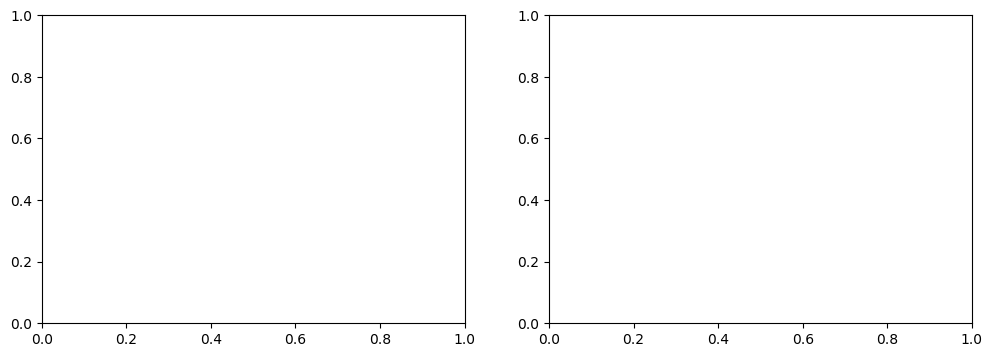

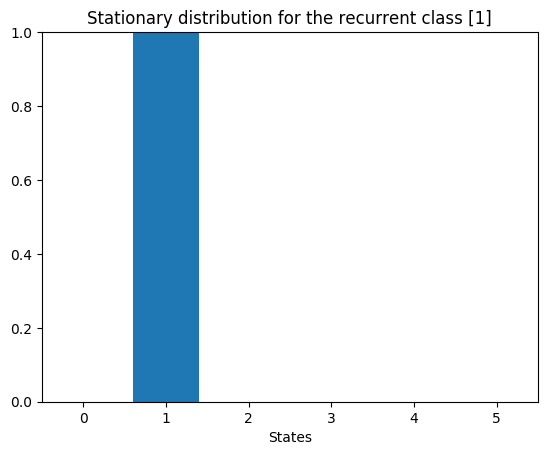

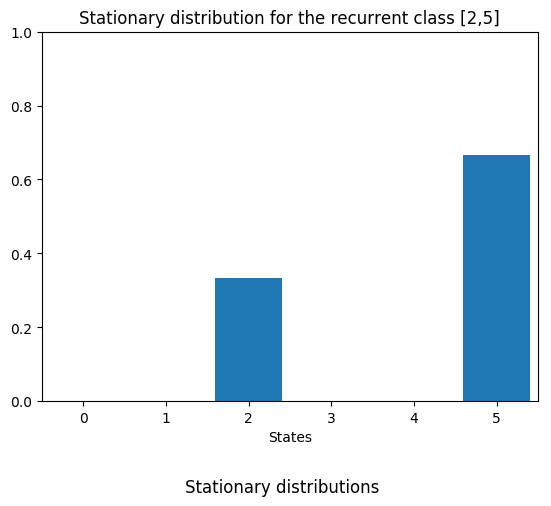

In [46]:
fig, axes = subplots(1, 2, figsize=(12, 4))
titles = ["Stationary distribution for the recurrent class $recurrent_class"
          for recurrent_class in recurrent_classes(mc1)]

for (ax, title, dist) in zip(axes, titles, stationary_distributions(mc1))
    draw_histogram(dist, ax=ax, title=title, xlabel="States")
end

suptitle("Stationary distributions", y=-0.05, fontsize=12)
show()

### Simulation

Let us simulate our Markov chain `mc1`.
The `simualte` method generates a sample path
of length given by the first argument, `ts_length`,
with an initial state as specified by an optional argument `init`;
if not specified, the initial state is randomly drawn. 

A sample path from state `1`:

In [49]:
simulate(mc1, 50, init=1)

50-element Array{Int64,1}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

As is clear from the transition matrix `P`,
if it starts at state `1`, the chain stays there forever,
i.e., `1` is an absorbing state, a state that constitutes a singleton recurrent class.

Start with state `2`:

In [54]:
simulate(mc1, 50, init=2)

50-element Array{Int64,1}:
 2
 5
 5
 5
 5
 2
 5
 2
 5
 5
 5
 2
 5
 ⋮
 2
 5
 2
 5
 2
 5
 2
 5
 2
 5
 5
 5

You can observe that the chain stays in the recurrent class $\{2,5\}$
and visits states `2` and `5` with certain frequencies.

If `init` is not specified, the initial state is randomly chosen:

In [52]:
simulate(mc1, 50)

50-element Array{Int64,1}:
 5
 5
 2
 5
 5
 2
 5
 5
 5
 2
 5
 5
 5
 ⋮
 5
 5
 2
 5
 5
 2
 5
 5
 2
 5
 2
 5

**Note on reproducibility**:
The `simulate` method offers an option `random_state` to set a random seed
to initialize the pseudo-random number generator.
As you provide the same random seed value,
`simulate` returns the same outcome.

For example, the following will always give the same sequence:
Note that simulate function in julia does not have the random_state argument.

In [56]:
#simulate(mc1, 50, random_state = 12345) #=> doesn't work in julia
#we can alternatively use the following srand() function
srand(12345) 
simulate(mc1, 50)

50-element Array{Int64,1}:
 3
 5
 2
 5
 2
 5
 5
 2
 5
 2
 5
 5
 5
 ⋮
 2
 5
 5
 5
 5
 5
 5
 2
 5
 5
 2
 5

#### Time series averages

Now, let us compute the frequency distribution along a sample path, given by
$$
\frac{1}{t} \sum_{\tau=0}^{t-1} \mathbf{1}\{X_{\tau} = s\}
\quad (s \in S).
$$

In [22]:
function time_series_dist(mc, t, init=nothing, random_state::Int=0)
    """
    Return the distribution of visits by a sample path of length t
    of mc with an initial state init.
    """
    if typeof(t) == Int #t is an int
        t_max = t
        ts_size = 1
        ts_array = [t]
        dim = 1
    else
        t_max = maximum(t)
        ts_size = length(t)  # t is an array
        ts_array = t
        dim = 2
    end
        
    srand(random_state)
    X = simulate(mc, t_max, [init])
    dists = zeros((ts_size, n_states(mc)))
    bins = 1:n_states(mc)
    for (i, length) in enumerate(ts_array)
        e, bin_edges = hist(X[1:length], bins)
        dists[i, :] = e / length
    end
    
    if dim == 1
        return dists[1]
    else
        return dists
    end
end

time_series_dist (generic function with 3 methods)

Here is a frequency distribution along a sample path,  of length 100,
from initial state `1`, which is a recurrent state:

In [23]:
time_series_dist(mc1, 100, 1)

0.01

Length 10,000:

In [24]:
time_series_dist(mc1, 10^4, 1)

0.0001

The distribution becomes close to the stationary distribution `(0, 1/3, 0, 0, 2/3, 0)`.

Plot the frequency distributions for a couple of different time lengths:

In [25]:
function plot_time_series_dists(mc, ts, init; seed=nothing, figsize=(12,4))
    dists = typeof(seed) == Int? time_series_dist(mc, ts, init, seed) : time_series_dist(mc, ts, init)

    fig, axes = subplots(1, length(ts), figsize=figsize)
    titles = ["t=$t" for t in ts]

    for (ax, title, dist) in zip(axes, titles, dists)
        draw_histogram(dist, ax=ax, title=title, xlabel="States")

        #fig.suptitle("Time series distributions with init=$init",
        #        y=-0.05, fontsize=12)
    end
    show()
end

plot_time_series_dists (generic function with 1 method)

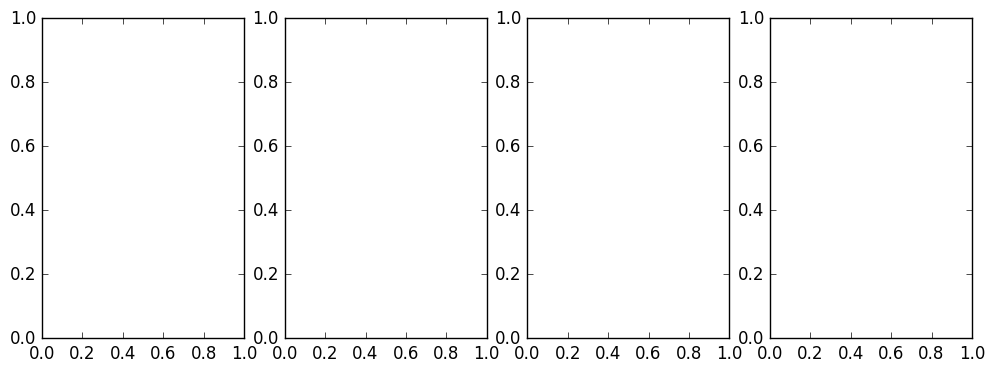

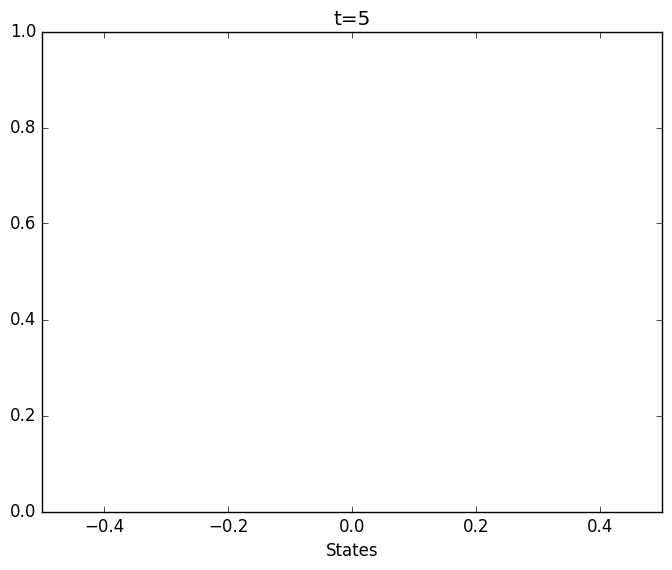

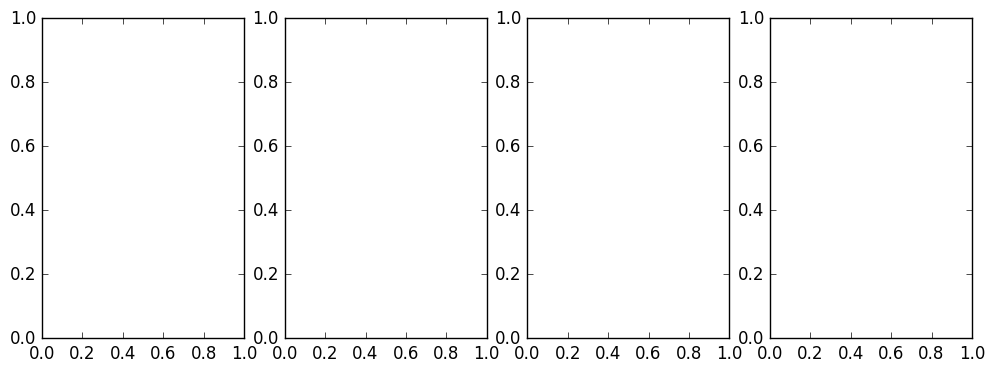

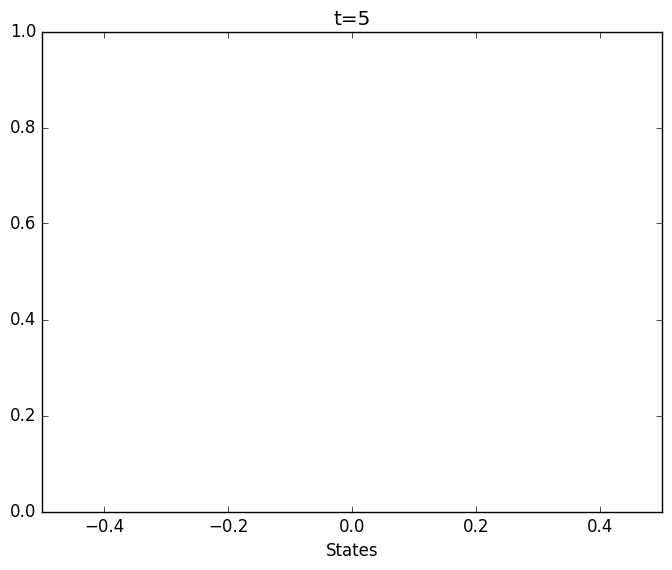

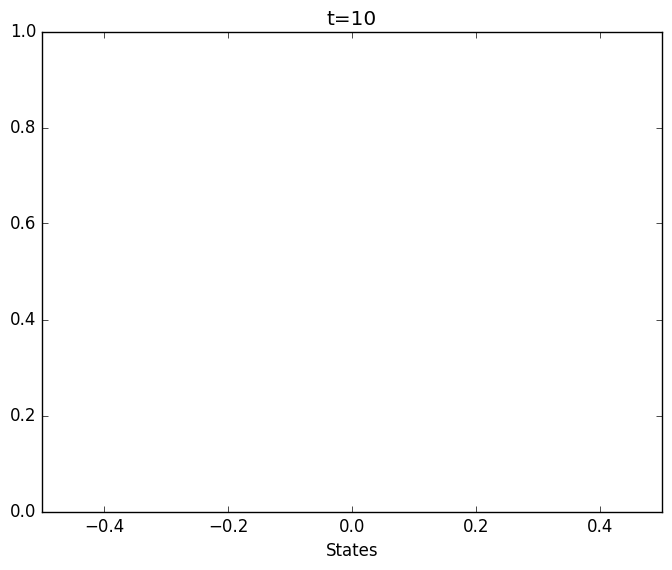

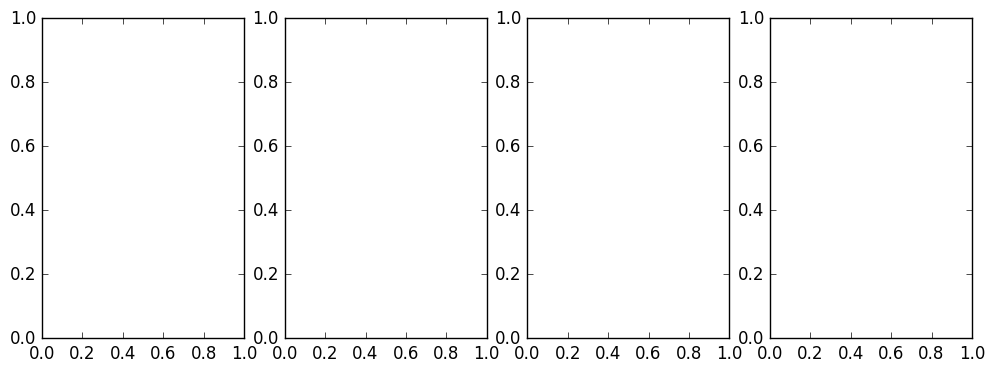

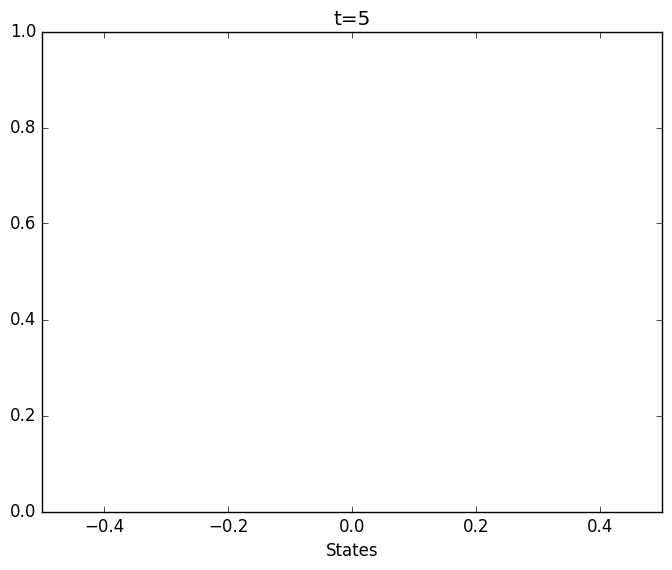

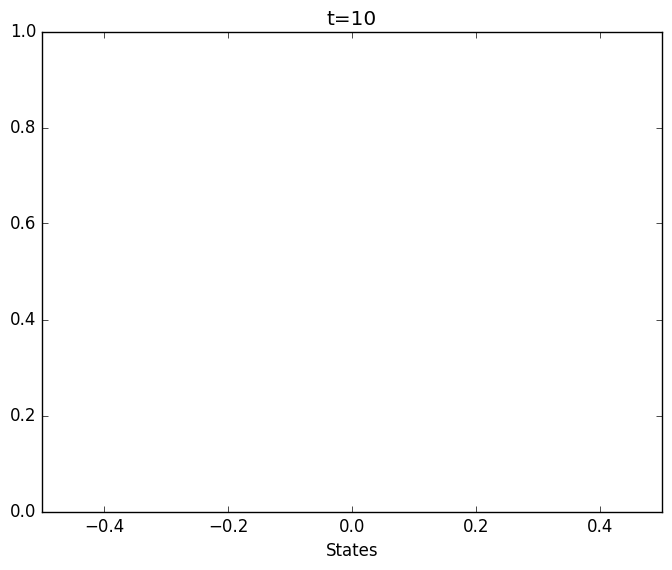

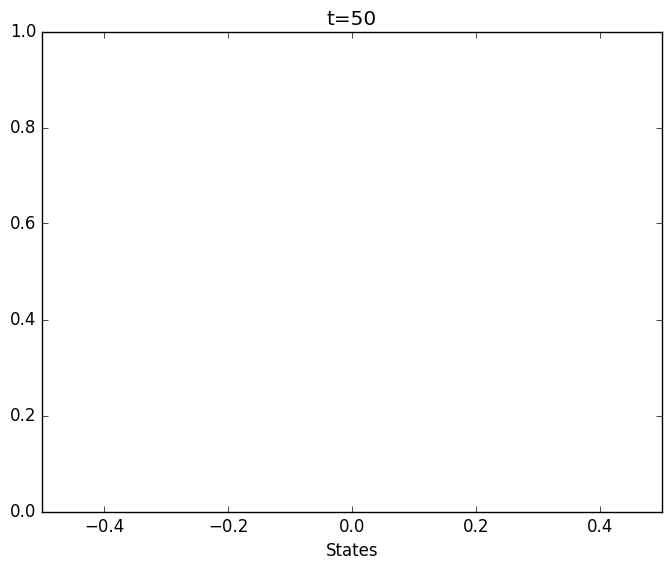

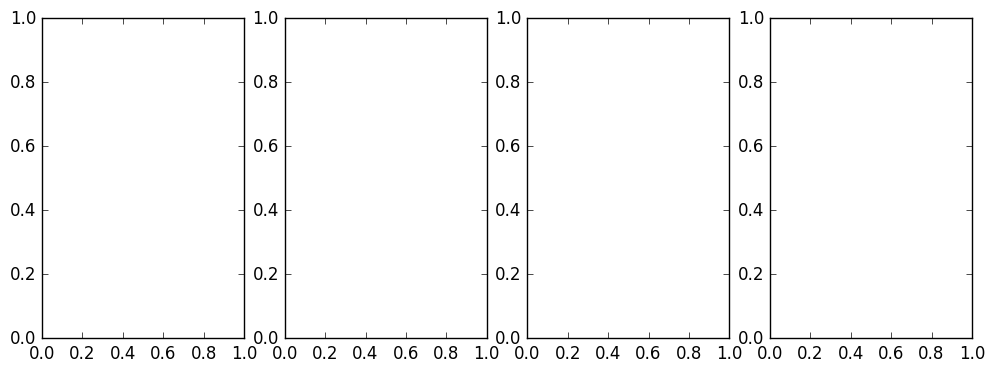

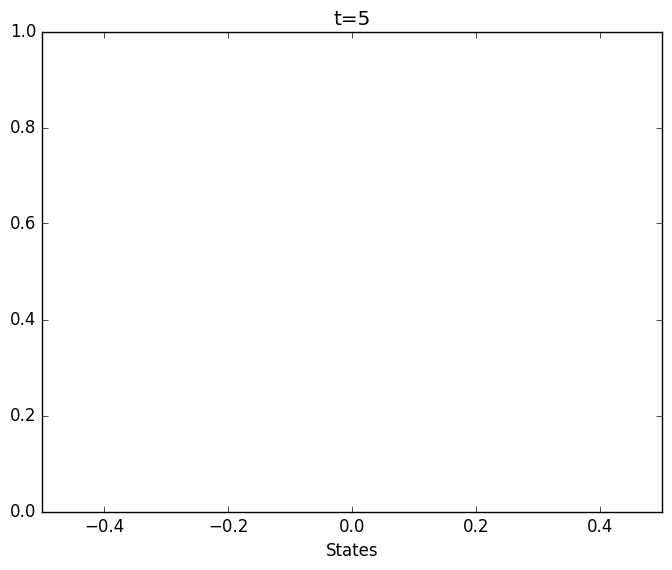

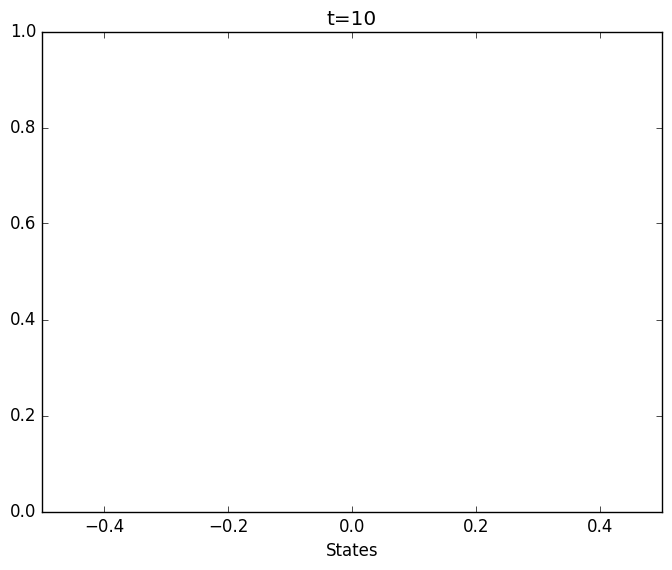

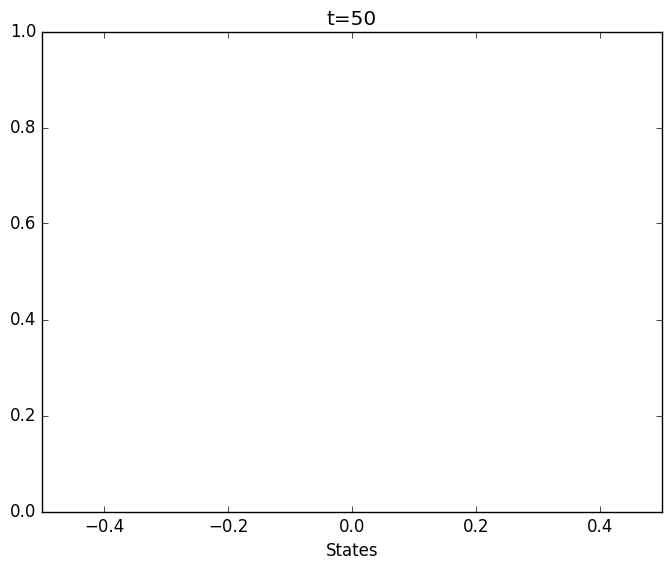

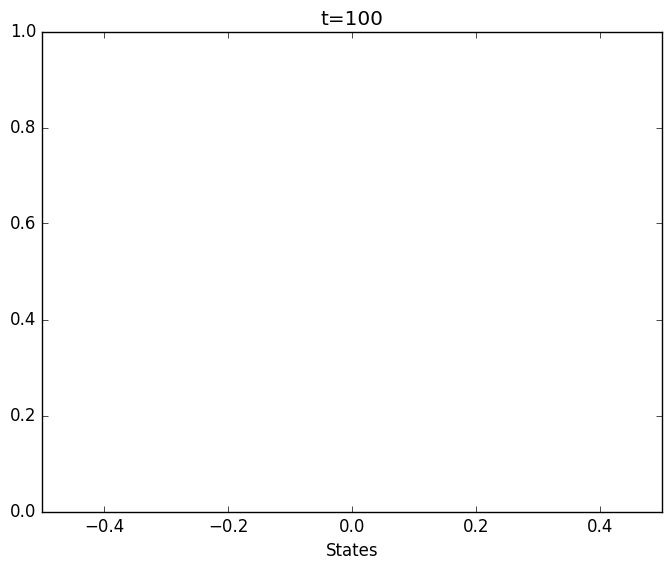

In [26]:
init = 1
ts = [5, 10, 50, 100]
plot_time_series_dists(mc1, ts, init)

Start with state `2`,
which is a transient state:

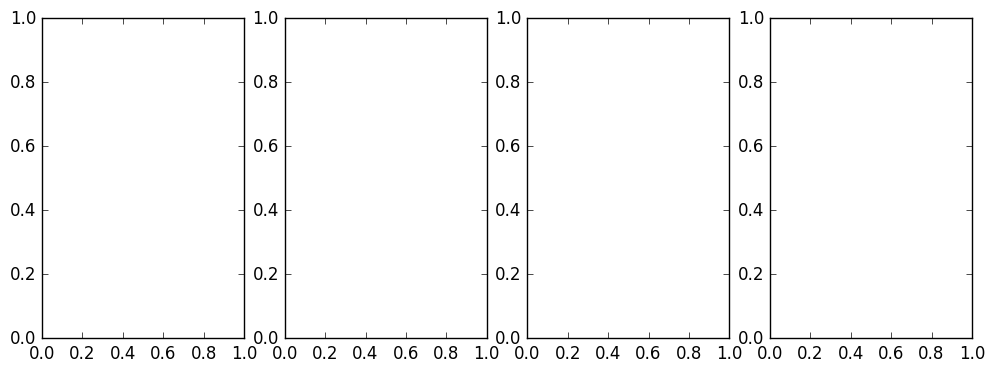

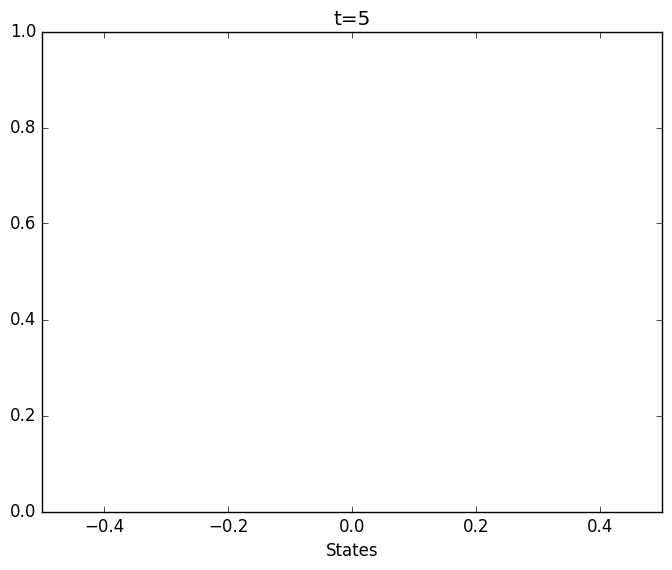

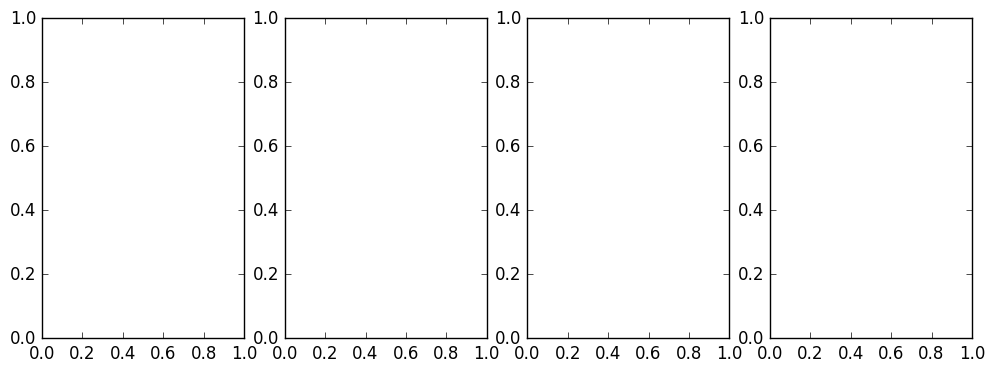

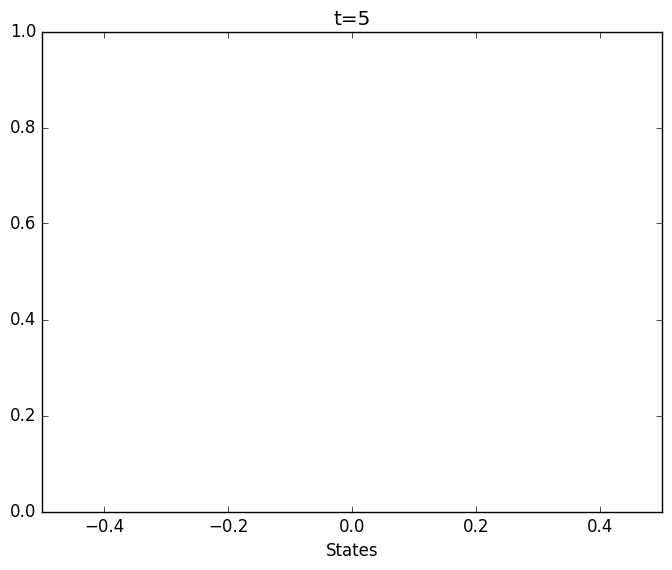

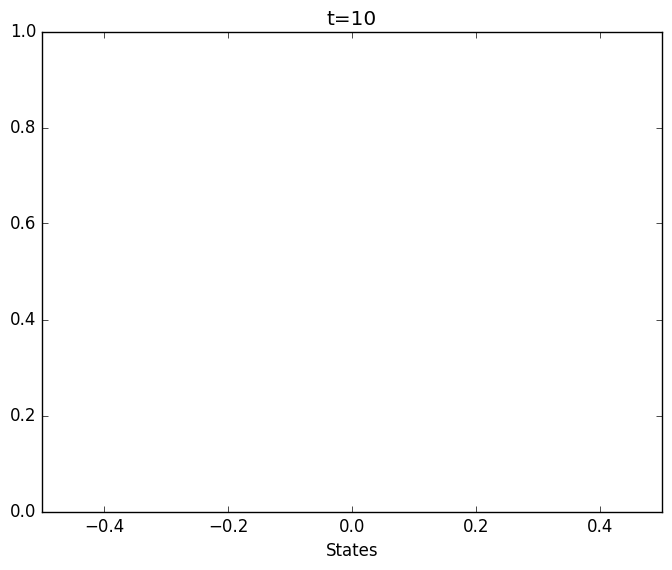

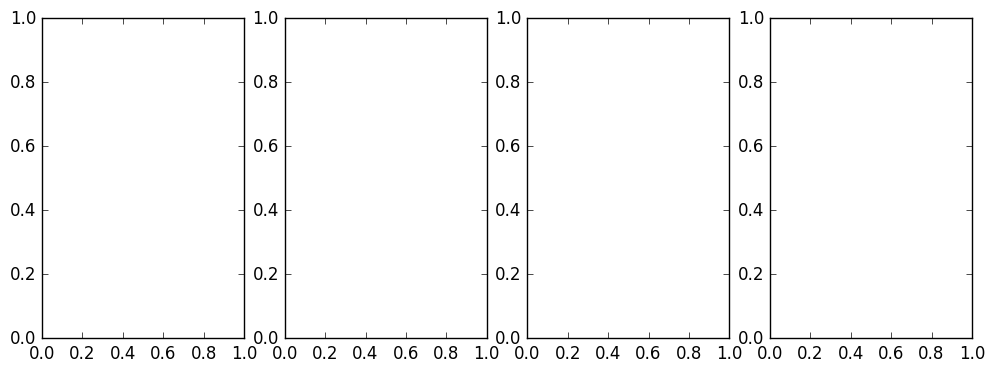

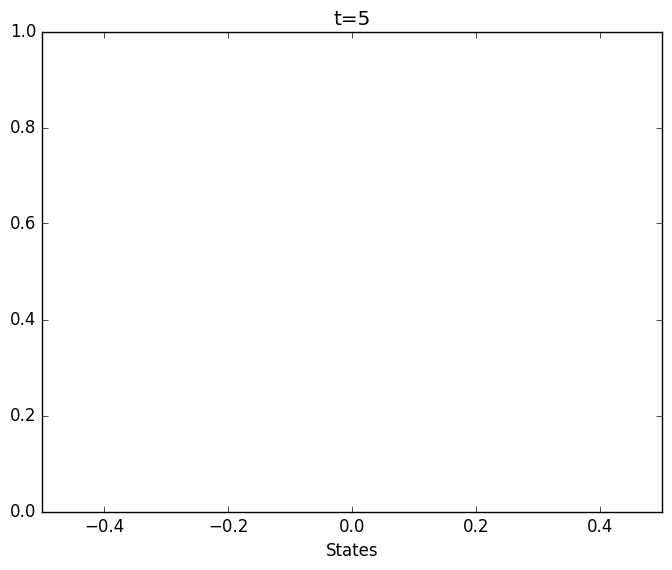

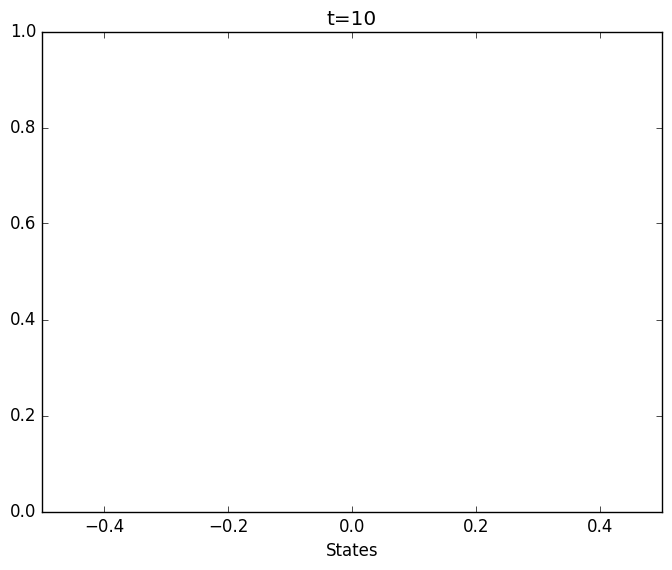

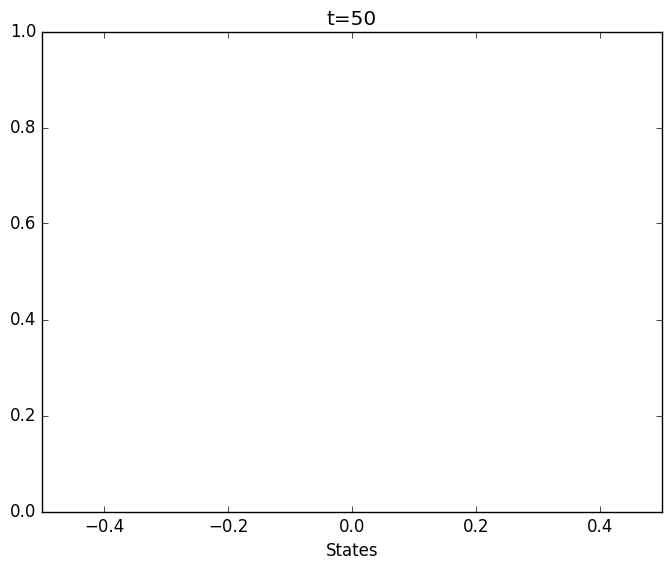

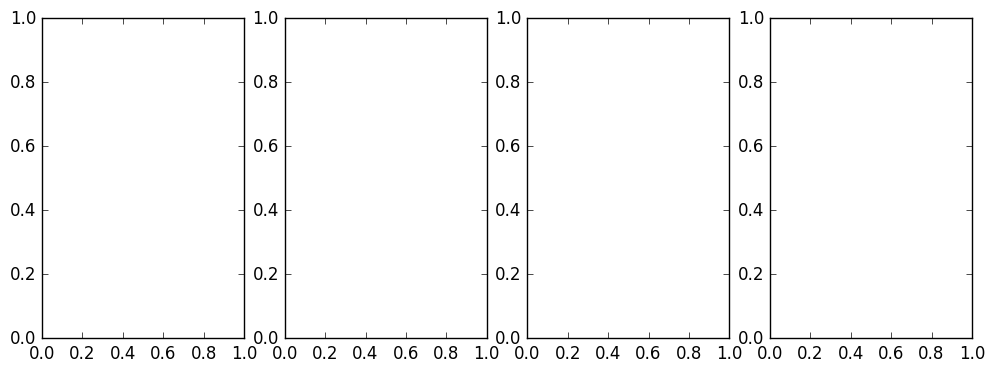

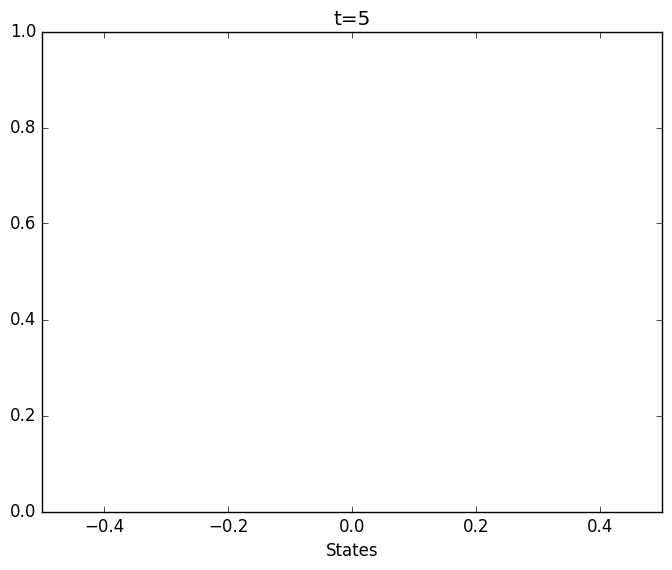

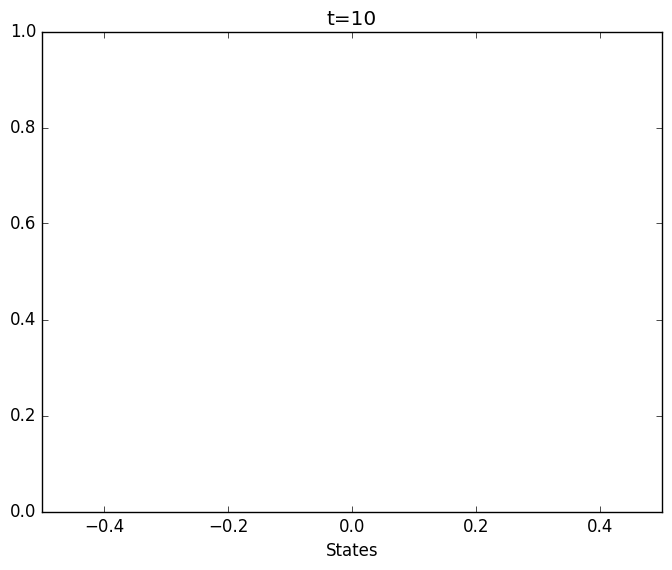

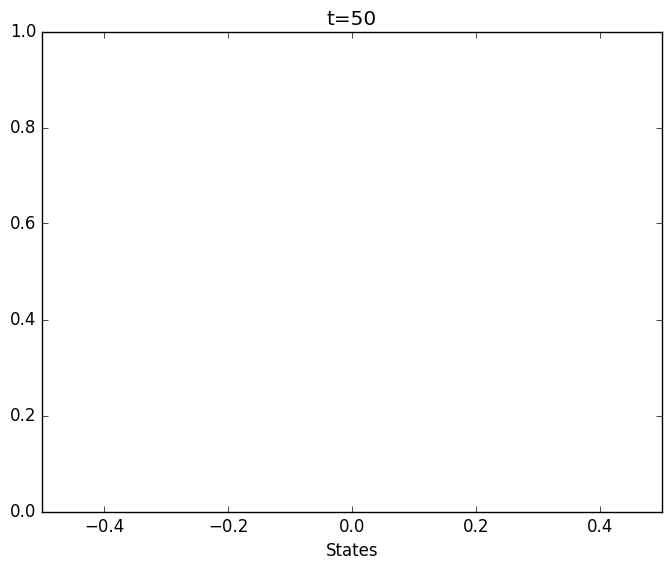

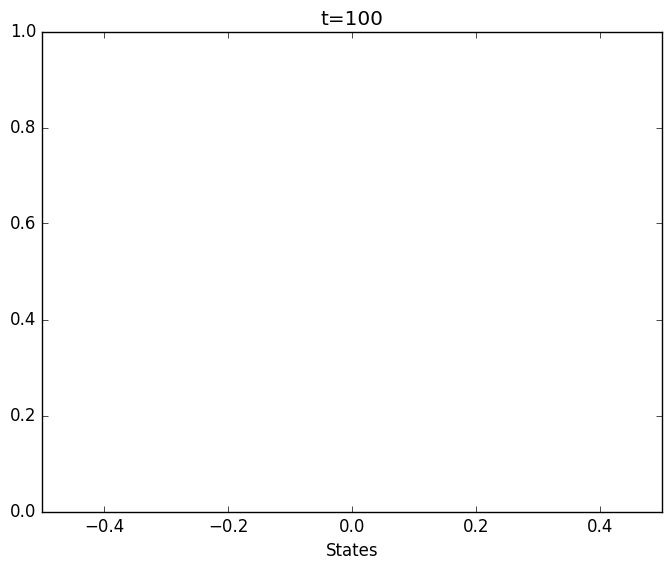

In [27]:
init = 2
ts = [5, 10, 50, 100]
plot_time_series_dists(mc1, ts, init)

Run the above cell several times;
you will observe that the limit distribution differs across sample paths.
Sometimes the state is absorbed into the recurrent class $\{0\}$,
while other times it is absorbed into the recurrent class $\{1,4\}$.

In [28]:
init = 2
ts = [5, 10, 50, 100]
seeds = [222, 2222]
descriptions = ["{0} sample path with init={1}".format(adjective, init) for adjective
    in ["Some"] + ["Another"] + ["Yet another"]*(length(seeds)-1)]

for seed, description in zip(seeds, descriptions)
    print(description)
    plot_time_series_dists(mc1, ts, init, seed=seed)
end

LoadError: LoadError: syntax: invalid character literal
while loading In[28], in expression starting on line 4

In fact,
for almost every sample path of a finite Markov chain $\{X_t\}$,
for some recurrent class $C$ we have
$$
\frac{1}{t} \sum_{\tau=0}^{t-1} \mathbf{1}\{X_{\tau} = s\} \to \psi^C[s]
\quad \text{as $t \to \infty$}
$$
for all states $s$,
where $\psi^C$ is the stationary distribution associated with the recurrent class $C$.

If the initial state $s_0$ is a recurrent state,
then the recurrent class $C$ above is the one that contains $s_0$,
while if it is a transient state,
then the recurrent class to which the convergence occurs depends on the sample path.

Let us simulate with the remaining states, `3`, `4`, and `5`.

In [42]:
inits = [3, 4, 5]
t = 100

fig, axes = subplots(1, 3, figsize=(12, 3))

for (init, ax) in zip(inits, axes)
    draw_histogram(time_series_dist(mc1, t=t, init=init), ax=ax,
    title="Initial state = $init",
                   xlabel="States")
end

suptitle("Time series distributions for t=$t",
             y=-0.05, fontsize=12)
show()

LoadError: LoadError: ArgumentError: function time_series_dist does not accept keyword arguments
while loading In[42], in expression starting on line 6

#### Cross sectional averages

Next, let us repeat the simulation for many times (say, 10,000 times)
and obtain the distribution of visits to each state at a given time period `T`.
That is, we want to simulate the marginal distribution at time `T`.

In [43]:
function cross_sectional_dist(mc, T; init=None, num_reps=10^4, random_state=0)
    """
    Return the distribution of visits at time T by num_reps times of simulation
    of mc with an initial state init.
    
    """
    if typeof(T) == Int  # T is an int
        T_max = T
        Ts_size = 1
        Ts_array = [T]
        dim = 1
    else
        T_max = maximum(T)
        Ts_size = length(T)  # T is an array
        Ts_array = T
        dim = 2
    end
    
    srand(random_state)
    x = simulate(mc, ts_length=T_max+1, init=init, num_reps=num_reps)[:, Ts_array]
    dists = zeros((x.shape[-1], n_states(mc))
    bins = np.arange(n_states(mc))
    for i in range(x.shape[-1])
        hist, bin_edges = np.histogram(x[:, i], bins=bins)
        dists[i, :] = hist / num_reps
    end
    
    if dim == 1
        return dists[1]
    else
        return dists
    end
end

LoadError: LoadError: syntax: missing comma or ) in argument list
while loading In[43], in expression starting on line 22

Start with state `1`:

In [31]:
init = 1
T = 10
cross_sectional_dist(mc1, init=init, T=T)

LoadError: LoadError: UndefVarError: cross_sectional_dist not defined
while loading In[31], in expression starting on line 3